In [1]:
import os
import pandas as pd

from geoframepy.whetgeo1d import grid_creator
from geoframepy.whetgeo1d import grid_to_netcdf

import warnings
warnings.filterwarnings('ignore')


project_path = os.path.dirname(os.getcwd())


grid_input_file_name = project_path + "/data/Grid_input/E3_grid.csv"

ic_input_file_name = project_path + "/data/Grid_input/E3_ic.csv"

parameter_input_file_name = project_path + "/data/Grid_input/Richards_VG.csv"

dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"

grid_type = 'classical'

dz_min = -9999 # not required for grid_type = 'classical'

dz_max = -9999 # not required for grid_type = 'classical'

b = -9999      # not required for grid_type = 'classical'

psi_interp_model = "linear"

T_interp_model = "linear"

water_ponding_0 = -3.0

T_water_ponding_0 = 273.15

output_file_name =  project_path + "/data/Grid_NetCDF/E3_grid.nc"

output_title = '''Computational grid for Terreno 3.
                  '''
output_summary = '''
Type,eta,K,equationStateID,parameterID
L,0.0,50,1,2
L,-1.5,50,1,9
L,-3.0,0,nan,nan

eta,Psi0,T0
-0.0,-3.0,273.15
-3.0,0.0,273.15

'''

output_date = ''

output_institution = 'GEOframe'



In [2]:
data_grid = pd.read_csv(grid_input_file_name)
# print('Grid')
# print(data_grid)
# print()

data_ic = pd.read_csv(ic_input_file_name)
# print('IC')
# print(data_ic)
# print()

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')
# print('Parameter')
# print(data_parameter)
# print()

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume] = grid_creator.grid1D(data_grid, dz_min, b, dz_max, grid_type, shallow_water=True)

[psi_0, T_0] = grid_creator.set_initial_condition(data_ic, eta, psi_interp_model, T_interp_model, water_ponding_0=water_ponding_0, T_water_ponding_0=T_water_ponding_0, shallow_water=True)

control_volume_index = grid_creator.calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = grid_creator.set_parameters_richards(data_grid, data_parameter, data_dictionary, KMAX, eta)

grid_to_netcdf.write_grid_netCDF_richards(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)



***SUCCESS writing!  C:\Users\Luca\Documents\GitHub\WHETGEO1D_Idrologia_21_22/data/Grid_NetCDF/E3_grid.nc


## Setup the ex04.sim file <a class="anchor" id="setup"></a>

To setup the `ex_04.sim` you can:

- open it with a text editor

- use the text editor of Jupyter Notebook

- edit and save the file directly within this notebook. In this case you load the file with the magic `%load filename`, edit the file, save the file by calling `%%writefile filename` at the beginning of the cell containing the your file.

**Here a brief explanation on how to specify the input of the simulation.**

Firts of all we have to specify the file containing the computational grid

```groovy
    def richardsGridFileName = "$oms_prj//data/Grid_NetCDF/ex04_grid.nc"
```

This file contains all the data, geometrical quantities, soil parameters, and initial condition of the problem.


As said above the soil hydraulic properties are described by the van Genuchten model, so we specify
```groovy
def typeClosureEquation = "{Water Depth,Van Genuchten}"
def typeEquationState = "{Water Depth,Van Genuchten}"
def typeUHCModel = "{null,Mualem Van Genuchten}"
```
As regards the unsaturated hydraulic conductivity model, up to now we do not want to take into account the effect of soil temperature on the water viscosity thus we specify
```groovy
def typeUHCTemperatureModel = "notemperature"
```
Then it is necessary to prescribe how to evaluate the unsaturated hydraulic conductivity at the interface between two adjacent control volumes
```groovy
def interfaceHydraulicConductivityModel = "max"
```

Now we move to the definition of the boundary conditions: one at the soil surface (_top_) and at the bottom of the soil column (_bottom_). The boundary condition control the time evolution of the system and their must be consistent with the problem one wants to solve. In this example we couple the R2 with the shallow water equation thus we have
```groovy
def topBCType = "Top Coupled"
```

Regarding the bottom boundary condition, we assume that water flows downward accordingly to the gravity force, the gradient of $\psi$ is 0. 
```groovy
def bottomBCType = "Bottom Dirichlet"
```

The input variable 
```groovy
def maxPonding = 0.0
```
defines the maximum ponding water at the soil surface [m]. 0 is the default value and means that ponding is not limited.

Then we need to specify the start date and end date [yyyy-mm-dd hh:mm] of the simulation 
```groovy
def startDate= "2020-01-01 00:00"
def endDate="2020-01-04 00:00"
```
and the time step [minutes] of the time series of the boundary conditions 
```groovy
def tTimestep = 5
```

The components that read the time series require as input the header of the column containg the values. This header can be found at line 5 of each `.csv` and this value must be equal for all the files containing the time series of the simulation
```groovy
def stationID = "0"
```

The files containing the time series for the _top_ and _bottom_ boundary condition are respectively
```groovy
def topBCFileName = "$oms_prj//data/Timeseries/ex04_rainfall.csv"
def bottomBCFileName = "$oms_prj//data/Timeseries/ex04_constant_suction_minus2.csv"
```
To be noted that the in case of free drainage boundary condition we do not have to provide any value, but we must provide for the component responsible for reading the time series. 

Moreover, we provide another time series that specify for which date we want to save the output on the disk: 1 to save outputs, 0 otherwise
```groovy
def saveDatesFileName = "$oms_prj//data/Timeseries/ex04_save_dates.csv"
```

At last we can specify path of the output file. Usually output are save in the `output` folder of the project. If you prefer you can save it in a different folder the important thing is that the folder you specify exists
```groovy
def outputFileName = "$oms_prj//output/ex04.nc"
```

## Post-processing  <a class="anchor" id="post_processing"></a>

Once you have run the simulation, you can find the output in the folder `output`. The file is a netCDF and it can be easily read with the [xarray](http://xarray.pydata.org/en/stable/). 

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.style as style 
import matplotlib.colors as cl
import matplotlib.dates as mdates
import matplotlib
from geoframepy.timeseries import io_csv
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        "text.usetex": False,
        "font.family": "serif",
        "axes.labelsize": 16,
        "font.size": 16,
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ece7f2","#d0d1e6","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#023858"])
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

plt.rcParams.update(nice_fonts)

**Read the output file**

In [4]:
ds = xr.open_dataset(project_path + '/output/E3_grid_out_0000.nc')
ds

<xarray.Dataset>
Dimensions:           (depth: 101, dualDepth: 101, time: 1153)
Coordinates:
  * depth             (depth) float64 -2.985 -2.955 -2.925 ... -0.045 -0.015 0.0
  * dualDepth         (dualDepth) float64 -3.0 -2.97 -2.94 ... -0.06 -0.03 0.0
  * time              (time) datetime64[ns] 2022-01-01 ... 2022-01-05
Data variables:
    psi               (time, depth) float64 ...
    psiIC             (depth) float64 ...
    T                 (depth) float64 ...
    theta             (time, depth) float64 ...
    saturationDegree  (time, depth) float64 ...
    darcyVelocity     (time, dualDepth) float64 ...
    waterVolume       (time, depth) float64 ...
    error             (time) float64 ...
    topBC             (time) float64 ...
    bottomBC          (time) float64 ...
    runOff            (time) float64 ...
    controlVolume     (depth) float64 ...
Attributes:
    Description_of_the_problem:         WHETGEO-1D ex04.
    Top_boundary_condition:             Top Coupled
    Bottom_boundary_condition:          Bottom Neumann
    path_top_boundary_condition:        C:\Users\super\OMS_Project_WHETGEO1D_...
    path_bottom_boundary_condition:     C:\Users\super\OMS_Project_WHETGEO1D_...
    path_grid:                          C:\Users\super\OMS_Project_WHETGEO1D_...
    time_delta:                          
    swrc_model:                         {Water Depth,Van Genuchten}
    soil_hydraulic_conductivity_model:  {null,Mualem Van Genuchten}
    interface_conductivity_model:       max

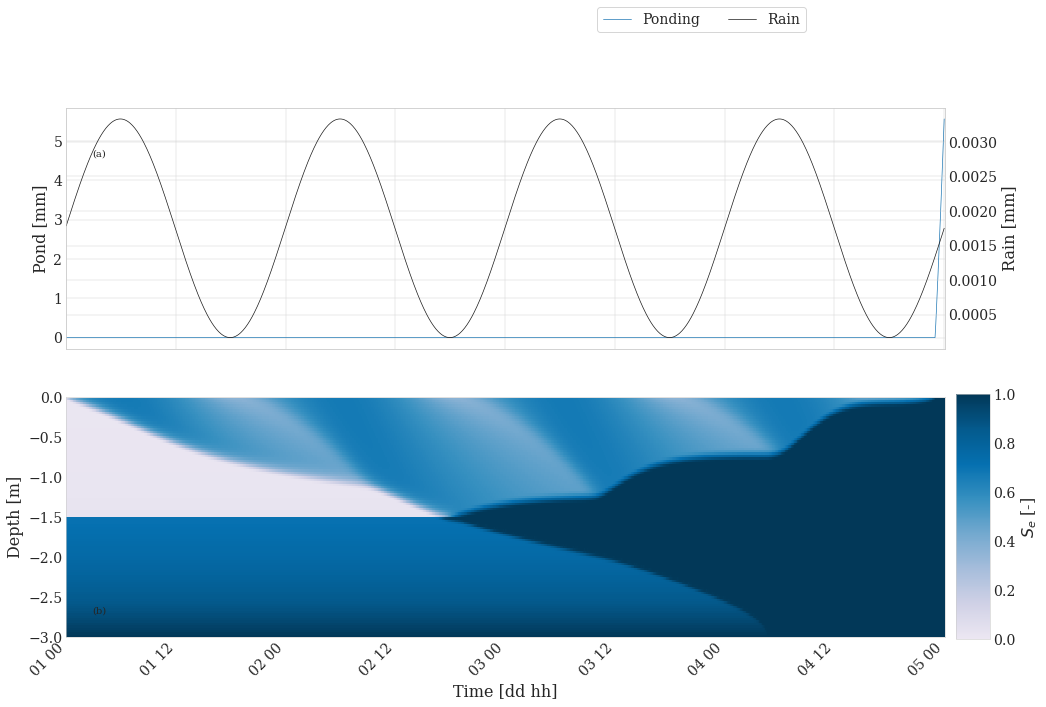

In [5]:
line_w = 0.7

start_date = '2022-01-01 00:00'
end_date = '2022-01-05 00:00'

plot_width = 40/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds.time.sel(time=slice(start_date, end_date)).values, ds.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds.time.sel(time=slice(start_date, end_date)).values, ds.topBC.sel(time=slice(start_date,end_date))/300, label='Rain', linewidth=line_w, color='0.1')

ax0twin.set_ylabel('Rain [mm]')
ax[0].set_ylabel('Pond [mm]')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.85,1.45) , ncol=2)


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
im = ds.saturationDegree.where(ds.depth<0.0).sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$S_e$ [-]')

#ax[0].axvline(x=ds.time.sel(time='2022-01-01 10:35').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
#ax[0].axvline(x=ds.time.sel(time='2022-01-01 17:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=10,
             transform=ax[0].transAxes)
plt.text( 0.03,0.1, '(b)', fontsize=10,
             transform=ax[1].transAxes)


plt.show()

In [6]:
ds_deep = xr.open_dataset(project_path + '/output/E3_deep_out_0000.nc')
# ds

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\Luca\\Documents\\GitHub\\WHETGEO1D_Idrologia_21_22\\output\\E3_deep_out_0000.nc'

In [ ]:
line_w = 0.7

start_date = '2022-01-01 00:00'
end_date = '2022-01-05 00:00'

plot_width = 40/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds_deep.time.sel(time=slice(start_date, end_date)).values, ds_deep.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds_deep.time.sel(time=slice(start_date, end_date)).values, ds_deep.topBC.sel(time=slice(start_date,end_date))/300, label='Rain', linewidth=line_w, color='0.1')

ax0twin.set_ylabel('Rain [mm]')
ax[0].set_ylabel('Pond [mm]')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.85,1.45) , ncol=2)


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
im = ds_deep.saturationDegree.where(ds_deep.depth<0.0).sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$S_e$ [-]')

#ax[0].axvline(x=ds_deep.time.sel(time='2020-01-01 10:35').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
#ax[0].axvline(x=ds_deep.time.sel(time='2020-01-01 17:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H %m'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=10,
             transform=ax[0].transAxes)
plt.text( 0.03,0.1, '(b)', fontsize=10,
             transform=ax[1].transAxes)


plt.show()